# Trump Tweets at the Internet Archive

So Trump's Twitter account is gone. At least at twitter.com. But (fortunately for history) there has probably never been a more heavily archived social media account at the Internet Archive and elsewhere on the web. There are also a plethora of online "archives" like [The Trump Archive](https://www.thetrumparchive.com/) which have collected these tweets as data. But seeing the tweets as they appeared in the browser is important. Of course you can go view the account in the Wayback Machine and [browse around](https://web.archive.org/web/20210107055108/https://twitter.com/realDonaldTrump) but what if we wanted a list of all the Trump tweets? How many times were these tweets actually archived?

## CDX API

The Wayback Machine (and many other web archives) have a service called the [CDX API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server). Think of it as the index to the archive. You can give it a URL and it'll tell you what snapshots it has for it. You can also ask the CDX API to search for a *url prefix* and it will tell you what snapshots it has that start with that string. Lets use the handy [wayback](https://wayback.readthedocs.io/en/stable/usage.html) Python module to search for tweet URLs in the Wayback machine. So URLs that look like:

    https://twitter.com/realDonaldTrump/status/{id}

In [121]:
! pip install wayback

The search() method handles paging through the API results using a resumption token behind the scenes. Lets look at the first 100 results just to see what they look like.

In [1]:
from wayback import WaybackClient

wb = WaybackClient()

count = 0
for result in wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix'):
    print(result.url)
    count += 1
    if count > 100:
        break

https://twitter.com/realDonaldTrump/status/%22/6ixpercent/status/642559156784775168%22
https://twitter.com/realDonaldTrump/status/%22/6ixpercent/status/645771399726919680%22
https://twitter.com/realdonaldtrump/status/%22/BeauJohnson4/status/481467498248671233%22
https://twitter.com/realDonaldTrump/status/%22/bobby_stokes/status/497930146968395776%22
https://twitter.com/realDonaldTrump/status/%22/CharlesWoodso10/status/652578215400046592%22
https://twitter.com/realDonaldTrump/status/%22/El_Grinchh/status/637030969338294272%22
https://twitter.com/realdonaldtrump/status/%22/jefftiedrich/status/481830345814188034%22
https://twitter.com/realDonaldTrump/status/%22/JesusLezz/status/651908920714371072%22
https://twitter.com/realDonaldTrump/status/%22/jimmygarner/status/652537219694108673%22
https://twitter.com/realDonaldTrump/status/%22/LittelCaesar/status/497929766230831104%22
https://twitter.com/realDonaldTrump/status/%22/PattyDs50/status/637067362353704960%22
https://twitter.com/realDonaldT

So there are some weird URLs in there, that look like the result of buggy automated archive processes that aren't constructing URLs properly?

* https://twitter.com/realDonaldTrump/status/%22/SyakibPutera/status/636601131339087872%22
* https://twitter.com/realDonaldTrump/status/'+twitter_id+

And then we can see lots of results for the same URL such as https://twitter.com/realDonaldTrump/status/1000061992042975232 repeated over and over. This is because that URL was archived at multiple points in time. So lets improve on this to filter out the URLs that don't look like tweet URLs, and to only emit the unique ones. But still we'll just look at the first 100 results to make sure things are working properly.

In [25]:
import re

seen = set()

for result in wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix'):
    if re.search(r'/realDonaldTrump/status/\d+', result.url):
        if result.url not in seen:
            print(result.url)
            seen.add(result.url)
            if len(seen) > 100:
                break

https://twitter.com/realDonaldTrump/status/0?s=19
https://twitter.com/realDonaldTrump/status/0n/7
http://twitter.com/realDonaldTrump/status/1000061992042975232
https://twitter.com/realDonaldTrump/status/1000061992042975232
https://www.twitter.com/realDonaldTrump/status/1000061992042975232
https://twitter.com/realDonaldTrump/status/1000061992042975232?lang=en
https://twitter.com/realDonaldTrump/status/1000061992042975232?lang=en-gb
https://twitter.com/realDonaldTrump/status/1000061992042975232?ref_src=twcamp%5Ecopy%7Ctwsrc%5Eandroid%7Ctwgr%5Ecopy%7Ctwcon%5E7090%7Ctwterm%5E3
https://twitter.com/realDonaldTrump/status/1000061992042975232?ref_src=twsrc%5Etfw
http://twitter.com/realDonaldTrump/status/1000064605903876096
https://twitter.com/realDonaldTrump/status/1000064605903876096
https://www.twitter.com/realDonaldTrump/status/1000064605903876096
https://twitter.com/realDonaldTrump/status/1000064605903876096?ref_src=twsrc%5Etfw
http://twitter.com/realDonaldTrump/status/1000114139136606209


This list shows that some tweet URLs can have query strings, which modify the presentation of the tweet in various ways. For example to change the language of the user interface:

* https://twitter.com/realDonaldTrump/status/1000114139136606209?lang=en-gb

Or to highlight certain information:

* https://twitter.com/realDonaldTrump/status/1000114139136606209?conversation_id=1000114139136606209

The query parameters are essential for finding the right view in the Wayback Machine. But the different variants don't really matter if we are simply wanting to count the number of tweets that are archived. Also it looks like some URLs aren't for the tweets themselves, but for components of the tweet, like video:

* https://twitter.com/realDonaldTrump/status/1000114139136606209/video/1

The process can be adjusted to parse the URL to ensure the path is for an actual tweet, not a tweet component. The tweet id can also be extracted from the path in order to track whether it has been seen before.

In [26]:
from urllib.parse import urlparse

seen = set()

for result in wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix'):
    uri = urlparse(result.url)
    
    m = re.match(r'^/realDonaldTrump/status/(\d+)/?$', uri.path, re.IGNORECASE)
    if not m:
        continue
        
    tweet_id = m.group(1)
    if tweet_id not in seen:
        print(result.url)
        seen.add(tweet_id)
            
    if len(seen) > 100:
        break

https://twitter.com/realDonaldTrump/status/0?s=19
http://twitter.com/realDonaldTrump/status/1000061992042975232
http://twitter.com/realDonaldTrump/status/1000064605903876096
http://twitter.com/realDonaldTrump/status/1000114139136606209
http://twitter.com/realDonaldTrump/status/1000138164923781121
http://twitter.com/realDonaldTrump/status/1000145873274359809
http://twitter.com/realDonaldTrump/status/1000151354701213696
http://twitter.com/realDonaldTrump/status/1000152863035805696
http://twitter.com/realDonaldTrump/status/1000174070061813761
http://twitter.com/realDonaldTrump/status/1000366478846300165
http://twitter.com/realDonaldTrump/status/1000375761604370434
http://twitter.com/realDonaldTrump/status/1000385794115325952
http://twitter.com/realDonaldTrump/status/1000387893427351553
http://twitter.com/realDonaldTrump/status/1000391997969092608
http://twitter.com/realDonaldTrump/status/1000396430371106817
http://twitter.com/realDonaldTrump/status/1000458567147839488
http://twitter.com/r

It looks like this is actually working pretty good. For completeness we can store a mapping of the tweet id to all the results for that tweet id. This will allow us to track how many tweet have been archiving, while letting us examing how many times that tweet was archived, and what their precise URLs are for playback.

This time we can let it keep running to get all the results.

In [27]:

from collections import defaultdict

tweets = defaultdict(list)

for result in wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix'):
    uri = urlparse(result.url)
    
    m = re.match(r'^/realDonaldTrump/status/(\d{8,})/?$', uri.path, re.IGNORECASE)
    if not m:
        continue
        
    tweet_id = m.group(1)
    tweets[tweet_id].append(result)

Now we can see the tweet ids. Instead of printing them all out we can just look at the first 100:

In [5]:
list(tweets.keys())[0:100]

['1000061992042975232',
 '1000064605903876096',
 '1000114139136606209',
 '1000138164923781121',
 '1000145873274359809',
 '1000151354701213696',
 '1000152863035805696',
 '1000174070061813761',
 '1000366478846300165',
 '1000375761604370434',
 '1000385794115325952',
 '1000387893427351553',
 '1000391997969092608',
 '1000396430371106817',
 '1000458567147839488',
 '1000462031500099584',
 '1000465814192099330',
 '1000554657859670016',
 '1000718611688943616',
 '1000726832843501570',
 '1000741764565753856',
 '1000831304836018176',
 '1000837182297464832',
 '100089437434477630',
 '1001055932376387584',
 '1001085207825534976',
 '1001099771602456576',
 '1001103028626345984',
 '1001108964216537089',
 '1001149367271686145',
 '1001149793496977408',
 '1001151001699803138',
 '1001212077699149825',
 '1001220050995511298',
 '1001404640796336128',
 '1001410457092218880',
 '1001415199516254208',
 '1001417880116891650',
 '1001420270094168064',
 '1001424695126880258',
 '1001455721588969472',
 '100180717424971

And we can look at when a given tweet was archived too, irrespective of the various query strings that can be part of it. Here we get all the snapshots for tweet id 1002298565299965953 and print out the times that it was archived, in descending order. 

In [6]:
for result in sorted(tweets['1002298565299965953'], key=lambda r: r.timestamp, reverse=True):
    print(result.timestamp)

2021-01-08 13:24:02+00:00
2020-11-25 02:50:00+00:00
2020-11-15 17:00:34+00:00
2020-11-09 02:37:14+00:00
2020-11-09 02:37:14+00:00
2020-11-06 08:20:49+00:00
2020-11-06 05:32:52+00:00
2020-10-11 09:07:44+00:00
2020-07-10 17:13:56+00:00
2020-06-30 18:27:42+00:00
2020-06-30 18:26:24+00:00
2020-06-16 20:52:42+00:00
2020-06-07 07:43:55+00:00
2019-11-10 07:27:23+00:00
2019-09-11 04:17:42+00:00
2019-09-11 04:17:25+00:00
2019-08-25 17:20:01+00:00
2019-08-25 10:14:36+00:00
2019-06-13 09:14:18+00:00
2019-05-13 13:45:24+00:00
2019-05-05 01:44:53+00:00
2018-12-29 05:30:13+00:00
2018-11-27 19:12:03+00:00
2018-08-22 14:21:16+00:00
2018-06-05 13:07:07+00:00
2018-06-05 08:38:29+00:00
2018-06-05 08:38:27+00:00
2018-06-05 08:38:24+00:00
2018-06-05 08:38:22+00:00
2018-06-05 08:38:20+00:00
2018-06-05 08:38:18+00:00
2018-06-05 08:38:16+00:00
2018-06-05 08:38:14+00:00
2018-06-05 08:38:12+00:00
2018-06-05 08:38:10+00:00
2018-06-05 08:38:09+00:00
2018-06-05 08:38:07+00:00
2018-06-05 08:38:05+00:00
2018-06-05 0

In [7]:
len(tweets['1002298565299965953'])

253

So this particular URL was archived 252 times! The snapshots start on May 31, 2018 and most of the snapshots are from a few days of that. But there are also a handful of snapshots in 2019 and 2020. Examining [one of the snapshots] shows that it was sent on May 31st at 2:19 PM. It's hard to tell what time zone the display was generated for. But since the first snapshot was at May 31, 2018 at 21:19:36 UTC it is safe to assume that the display is for -07:00 UTC, or (given the time of year) Pacific Daylight Time.

The [overview](https://web.archive.org/web/20180101000000*/twitter.com/realDonaldTrump/status/1002298565299965953) gives a picture of some of these snapshots. But the nice thing about our index is that it factors in the way that the tweet ID is expressed in the URL. So we know more than what the URL specific overview shows. For example here are all the various URLs that were collected.

In [8]:
for result in sorted(tweets['1002298565299965953'], key=lambda r: r.timestamp, reverse=True):
    print(result.url)

https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://www.twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953?ref_src=twsrc%5Etfw
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realdonaldtrump/status/1002298565299965953
https://twitter.com/realDonaldTrump/status/1002298565299965953
https://twitter.com/realDonaldT

What was the most archived tweet?

In [9]:
sorted(tweets, key=lambda r: len(tweets[r]), reverse=True)[0]

'1006837823469735936'

In [10]:
len(tweets['1006837823469735936'])

23420

So https://twitter.com/realDonaldTrump/status/1006837823469735936 was archived 23,419 times?! It's interesting that the [overview page](https://web.archive.org/web/*/twitter.com/realDonaldTrump/status/1006837823469735936) only says 595 times, because it is looking at that exact URL. Looking at [the content](https://web.archive.org/web/20180613095659/twitter.com/realDonaldTrump/status/1006837823469735936) of the tweet it is understandable why this one was archived so much.

## Missing Data?

So what does the coverage look like? Before Trump's account was suspended [his profile](https://web.archive.org/web/20210107045727/https://twitter.com/realDonaldTrump/) indicated he has sent 59.6K tweets. The [TrumpTweetArchive](https://www.thetrumparchive.com/) also shows 56,571 tweets. How many tweet IDs did we find?

In [11]:
len(tweets)

24289

That is *a lot* less than what we should have found. So either there is a problem with my code, or the wayback module isn't paging results properly, or the CDX API isn't functioning properly, or not all of Trumps tweets have been archived?

In conversation with [Rob Brackett](https://robbrackett.com/) who is the principal author of the Python [wayback](https://pypi.org/project/wayback) library it seems that using the `limit` parameter can help return more results. So instead of doing:

    wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix')

the `limit` parameter should be used:

    wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix', limit=500000)

Here's Rob's explanation, which kind of begs more questions:

> Basically what’s happening here is that, without the `limit` parameter, the first page of results hits the maximum size and then, in that situation, does not include a resume key for moving on to the next page. Including a low enough limit (I think anything less than 1.5 million, but not sure) prevents you from hitting that ceiling and lets you successfully page through everything. When I do that, I get 64,329 tweet IDs across 16,253,658 CDX records (but the default Colab instance doesn’t have enough memory to store every record like you’re doing, so I had to just store the first record for each ID).

So lets give this a try. Rob noted that we're likely to consume all working memory storing all these CDX records in RAM. So lets persist them to a sqlite database instead.

In [6]:
import pathlib

data = pathlib.Path("data")
db_path = data / "trump-tweets.sqlite3"

In [7]:
import sqlite3

# only generate the sqlite db if it's not already there

if not db_path.is_file():
    
    db = sqlite3.connect(db_path)
    db.execute(
        '''
        CREATE TABLE tweets (
            tweet_id TEXT,
            url TEXT,
            timestamp DATETIME,
            mime_type TEXT,
            status_code INTEGER,
            digest TEXT,
            length INTEGER
        )
        '''
    )

    count = 0
    for result in wb.search('twitter.com/realDonaldTrump/status/', matchType='prefix', limit=500000):
        uri = urlparse(result.url)

        m = re.match(r'^/realDonaldTrump/status/(\d{8,})/?$', uri.path, re.IGNORECASE)
        if not m:
            continue

        tweet_id = m.group(1)    
        db.execute('INSERT INTO tweets VALUES (?, ?, ?, ?, ?, ?, ?)', [
            tweet_id,
            result.url,
            result.timestamp,
            result.mime_type,
            result.status_code,
            result.digest,
            result.length
        ])

        count += 1
        if count % 1000 == 0:
            db.commit()


    db.close()

Unfortunately GitHub won't let you upload the 3GB sqlite file--even with git-lfs enabled.

In [1]:
import sqlite3


In [2]:
db = sqlite3.connect("data/trump-tweets.sqlite3")

db.execute('SELECT COUNT(DISTINCT(tweet_id)) FROM tweets').fetchall()

[(64314,)]

So 65,314 tweets were found. That's quite a bit more than the 59k suggested by the Twitter display and the 56,571 by the Trump Archive. Let's limit to snapshots that had a 200 OK HTTP response. As we saw above it's possible people tried to archive bogus tweet URLs.

In [10]:
db.execute(
    '''
    SELECT COUNT(DISTINCT(tweet_id))
    FROM tweets
    WHERE status_code = 200
    ''').fetchall()

[(57292,)]

That seems a lot more like it. So what were the most archived tweet? Let's get the top 10.

In [9]:
cursor = db.execute(
    '''
    SELECT tweet_id,
        COUNT(*) AS total
    FROM tweets
    WHERE status_code = 200
    GROUP by tweet_id
    ORDER BY total DESC
    LIMIT 10
    '''
)

for row in cursor.fetchall():
    print(row)

('704834185471598592', 65486)
('704756216157839360', 65353)
('704818842153971712', 65350)
('796315640307060738', 55391)
('796182637622816768', 54854)
('796055597594578944', 54258)
('795733366842806272', 54243)
('796099494442057728', 54230)
('796126077647196160', 54180)
('794259252613414915', 54088)


So the most archived URL was archived 56,571 times:
    
    https://web.archive.org/web/20200521045242/https://twitter.com/realDonaldTrump/status/704834185471598592

The interface indicates it was archived 1,616 times, but remember we factored in alternate forms of the tweet URL. Lets see what those were.

In [10]:
cursor = db.execute(
    '''
    SELECT url,
        COUNT(*) as total
    FROM tweets
    WHERE tweet_id = "704834185471598592" 
        AND status_code = 200
    GROUP BY url
    ORDER BY total DESC
    '''
)

for row in cursor.fetchall():
    print(row)

('https://twitter.com/realDonaldTrump/status/704834185471598592', 1612)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=zh-tw', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=vi', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=ur', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=uk', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=tr', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=th', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=ta', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=sv', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=sr', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=sk', 1359)
('https://twitter.com/realdonaldtrump/status/704834185471598592?lang=ru', 1359)
('https://twitter.com/realdonaldtrump/status/

Now that is kind of fascinating. Why would there be 1,349 captures of each of those language specific URLs for this tweet? This seems like some kind of automation?

## Missing from Trump Archive?

So what tweets were found in the Internet Archive that are not in the Trump Archive. To figure this out we can first load in the Trump Archive tweets. This is relatively easy to do using the Google Drive download from their FAQ page.

In [29]:
import pandas

df = pandas.read_csv('https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6'
)

trump_archive = set([str(tweet_id) for tweet_id in df['id']])
len(trump_archive)

56571

Now we need the tweet ids from our sqlite db. Tweets will return a 200 OK and retweets will 301 Moved Permanently to the original tweet so we will include both here.

In [30]:
cursor = db.execute(
    '''
    SELECT DISTINCT(tweet_id)
    FROM tweets
    WHERE status_code in (200, 301)
    '''
)

wayback = set([r[0] for r in cursor.fetchall()])

len(wayback)

59637

Now we can see what tweet ids are in the Wayback Machine but not in the Trump Archive.

In [31]:
len(wayback - trump_archive)

3592

Wow. so 3592 tweets are in the Wayback Machine but not in the Trump Archive?! Let's spot check one of them to see if this is the case. Lets generate the Wayback URLs for the first 25 of these ids.

    https://web.archive.org/web/{datetime}/{url}

In [108]:
ids = list(wayback - trump_archive)[0:25]

cursor = db.execute(
    '''
    SELECT 
      "https://web.archive.org/web/" 
      || STRFTIME('%Y%m%d%H%M%S', timestamp) 
      || "/" 
      || url
    FROM tweets
    WHERE tweet_id IN ({})
    '''.format(",".join(["?"] * 25)),
    ids
)

for row in cursor.fetchall():
    print(row[0])

https://web.archive.org/web/20201108045542/https://twitter.com/realDonaldTrump/status/1080839175392321541
https://web.archive.org/web/20200706132436/http://twitter.com/realDonaldTrump/status/1280130505829224448
https://web.archive.org/web/20200706132436/https://twitter.com/realDonaldTrump/status/1280130505829224448
https://web.archive.org/web/20200706132436/https://twitter.com/realDonaldTrump/status/1280130505829224448
https://web.archive.org/web/20200706132437/https://twitter.com/realDonaldTrump/status/1280130505829224448
https://web.archive.org/web/20200706132437/https://twitter.com/realdonaldtrump/status/1280130505829224448
https://web.archive.org/web/20201115180905/https://twitter.com/realDonaldTrump/status/1280130505829224448
https://web.archive.org/web/20180411191618/https://twitter.com/realDonaldTrump/status/151737838684221441
https://web.archive.org/web/20200710183716/https://twitter.com/realDonaldTrump/status/151737838684221441
https://web.archive.org/web/20201106113805/https:

The first 5 of these seem to generate a *Something Went Wrong Page*. Perhaps there were tweets there and the Wayback Machine failed fetch them properly? Or maybe the data is there but failing to play back? It's hard to say with confidence.

https://web.archive.org/web/20201108045542/https://twitter.com/realDonaldTrump/status/1080839175392321541

<img src="images/twitter-something-went-wrong.png">

But then at least some of these appear to work such as:

* https://web.archive.org/web/20201106091445/https://twitter.com/realDonaldTrump/status/667434942826156032
* https://web.archive.org/web/20200307194518/https://twitter.com/realdonaldtrump/status/646009823356690432

The Trump Archive API can tell if they have these two:

    https://www.thetrumparchive.com/tweets/{tweet-id}

* https://www.thetrumparchive.com/tweets/667434942826156032
* https://www.thetrumparchive.com/tweets/646009823356690432

So it looks like there are definitely some realDonaldTrump tweets in the Internet Archive's Wayback Machine that are not in the Trump Archive. Some number less than 3,592. It would be necessary to somehow verify these to be sure. Here's a CSV of all the tweet IDs to see if they can be curated.

In [33]:
import csv

In [ ]:
out = csv.writer(open('data/trump-tweets-missing-from-archive.csv', 'w'))

out.writerow(['tweet_url', 'archive_url'])

for tweet_id in wayback - trump_archive:
    sql = """
        SELECT
            url, 
            STRFTIME('%Y%m%d%H%M%S', timestamp) AS timestamp
        FROM tweets
        WHERE tweet_id = ?
        ORDER BY timestamp DESC
        LIMIT 1
        """
    [tweet_url, timestamp] = db.execute(sql, [tweet_id]).fetchone()
    out.writerow([
        tweet_url,
        "https://web.archive.org/web/{}/{}".format(timestamp, tweet_url)
    ])
    print(tweet_url)

https://twitter.com/realDonaldTrump/status/918240536984801280
https://twitter.com/realDonaldTrump/status/315107115054276608
https://twitter.com/realDonaldTrump/status/455802609589583872
https://twitter.com/realDonaldTrump/status/303870510951981056
https://twitter.com/realdonaldtrump/status/1198672518833430534
https://twitter.com/realDonaldTrump/status/918305600810946561
https://twitter.com/realDonaldTrump/status/143769703230357504
https://twitter.com/realDonaldTrump/status/892775255835639808
https://twitter.com/realDonaldTrump/status/1140846462236073984
https://twitter.com/realDonaldTrump/status/179291529855246336
https://twitter.com/realDonaldTrump/status/443402398049251329
https://twitter.com/realDonaldTrump/status/883335550983450625
https://twitter.com/realDonaldTrump/status/296278885346209793
https://twitter.com/realDonaldTrump/status/329042069807054849
https://twitter.com/realDonaldTrump/status/900010432563433478
https://twitter.com/realDonaldTrump/status/313356899510804480
https:

https://twitter.com/realDonaldTrump/status/783106201403875329
https://twitter.com/realDonaldTrump/status/353467133734305792
https://twitter.com/realDonaldTrump/status/913539568888045568
https://twitter.com/realDonaldTrump/status/303662970473443328
https://twitter.com/realDonaldTrump/status/871835008788553729
https://twitter.com/realDonaldTrump/status/907725008033730560
https://twitter.com/realDonaldTrump/status/877162474172284928
https://twitter.com/realDonaldTrump/status/890588094193438722
https://twitter.com/realDonaldTrump/status/905125632249659393
https://twitter.com/realDonaldTrump/status/298868350048665601
https://twitter.com/realDonaldTrump/status/914519873161744384
https://twitter.com/realDonaldTrump/status/180319758518992896
https://twitter.com/realDonaldTrump/status/265134823729942528
https://twitter.com/realDonaldTrump/status/886229123621892096


## Missing from Internet Archive?

How about the other angle: are there any tweet ids in the Trump Archive that didn't come back from the CDX API?

In [109]:
len(trump_archive - wayback)

526

It appears yes?

In [110]:
trump_archive - wayback

{'1175115230457802752',
 '1175115237005152258',
 '1175267150799540224',
 '1175493003785449472',
 '1175564914901114882',
 '1175766589540405248',
 '1175884418122076165',
 '1177381112152305665',
 '1178510879488389120',
 '1178983018024841216',
 '1178987847132602368',
 '1179395773580140544',
 '1179596675280707585',
 '1179707468076781568',
 '1179723972407103489',
 '1179749665941676032',
 '1180323056050421761',
 '1180967311534149634',
 '1180967365686824960',
 '1181228767441833984',
 '1181419268677742595',
 '1181420455833538560',
 '1181420692572692480',
 '1181422696250384384',
 '1181425038618177536',
 '1181928424958578688',
 '1181931140740997120',
 '1181931277102063622',
 '1181931358857388035',
 '1181932389435678720',
 '1181934349433872384',
 '1182282909618704385',
 '1182282989096652802',
 '1182283090271592448',
 '1182843323091804160',
 '1182843529103429632',
 '1182843598779252737',
 '1182847457396310017',
 '1185181592572092416',
 '1185423180841832448',
 '1185533464700956672',
 '11855866488909

Lets examing the first one: 1175115230457802752. Is it in the Trump Archive?

https://www.thetrumparchive.com/tweets/1175115230457802752

Yes. It looks like a retweet of @FLOTUS:

    RT @FLOTUS: Welcome to the @WhiteHouse PM Morrison and Mrs. Morrison! 🇺🇸🇦🇺 https://t.co/kYznIkJf9H

But the redirect of the retweet is not in the Internet Archive:

https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/1175115230457802752

This in itself isn't too surprising because people wouldn't typically archive the retweet redirect. Are there any non-retweets in the Trump Archive but not in the Wayback Machine? To test that we need to examine the text of these tweets. Luckily we can look those up pretty easily using The Trump Archive API.

In [123]:
import requests

for tweet_id in trump_archive - wayback:
    url = "https://www.thetrumparchive.com/tweets/{}".format(tweet_id)
    resp = requests.get(url)
    if resp.status_code == 200:
        tweet = resp.json()
        if tweet['isRetweet'] == False:
            print("id: {}\ndate: {}\n{}\n".format(
                tweet['id'], 
                tweet['date'], 
                tweet['text']
            ))

id: 1237490722317746178
date: 2020-03-10T21:29:14.000Z
If you like automobils, how can you vote for a Democrat who all want to get rid of cars, as quickly as possible, especially if they are powered by gasoline. Remember also, no more than one car per family. I, on the other hand, have new plants being built all over Michigan, Plus!

id: 1281926278845812736
date: 2020-07-11T12:20:16.000Z
Roger Stone was targeted by an illegal Witch Hunt tha never should have taken place. It is the other side that are criminals, including the fact that Biden and Obama illegally spied on my campaign - AND GOT CAUGHT!

id: 1182847457396310017
date: 2019-10-12T02:36:24.000Z
RT @realDonaldTrump: Just landed in Louisiana! Vote against John Bel Edwards, he has the worst jobs record in the United States. Louisiana...

id: 1331749395214311427
date: 2020-11-25T23:59:33.000Z
https://t.co/FJ6UcmXq5G?

id: 1181420692572692480
date: 2019-10-08T04:06:57.000Z
RT @seanmdav: Lawmakers in both chambers have demanded that

In [126]:
for tweet_id in trump_archive - wayback:
    url = "https://www.thetrumparchive.com/tweets/{}".format(tweet_id)
    resp = requests.get(url)
    if resp.status_code == 200:
        tweet = resp.json()
        if not re.match(r'^"?RT', tweet['text']):
            print("id: {}\ndate: {}\ndeleted: {}\n{}\n".format(
                tweet['id'], 
                tweet['date'],
                tweet['isDeleted'],
                tweet['text']
            ))

id: 1237490722317746178
date: 2020-03-10T21:29:14.000Z
deleted: True
If you like automobils, how can you vote for a Democrat who all want to get rid of cars, as quickly as possible, especially if they are powered by gasoline. Remember also, no more than one car per family. I, on the other hand, have new plants being built all over Michigan, Plus!

id: 1281926278845812736
date: 2020-07-11T12:20:16.000Z
deleted: True
Roger Stone was targeted by an illegal Witch Hunt tha never should have taken place. It is the other side that are criminals, including the fact that Biden and Obama illegally spied on my campaign - AND GOT CAUGHT!

id: 1331749395214311427
date: 2020-11-25T23:59:33.000Z
deleted: True
https://t.co/FJ6UcmXq5G?



We can verify by looking in our database for a tweet id like 1281926278845812736:

In [127]:
db.execute('SELECT * FROM tweets WHERE tweet_id = ?', ["1281926278845812736"]).fetchall()

[('1281926278845812736',
  'https://twitter.com/realDonaldTrump/status/1281926278845812736',
  '2020-11-15 16:46:30+00:00',
  'text/html',
  404,
  'LUHTB5OHETT4Z6NFGFGNVN3Z4BJ3EDHT',
  3018)]

Sure enough, it looks like Internet Archive wasn't quite quick enough to pick this one up. It's hard to say when the tweet was deleted, but it was archived on 2020-11-15 which was well after when it was sent on 2020-07-11. 

But this is truly remarkable that the Wayback Machine only seems to be missing three original tweets (non-retweets), at least with respect with the Trump Archive. But since the Trump Archive appears to be missing at least some content that is present in the Wayback Machine its not exactly clear how accurate this is. In the end this highlights why it is important for Twitter to make an archival snapshot available.

## Archiving Activity

We can use our little SQLite database to plot the archiving activity related to Trump's tweets over time.

In [74]:
sql = \
    '''
    SELECT
        STRFTIME('%Y%m%d', timestamp) AS day,
        COUNT(*) AS "snapshots"
    FROM tweets
    GROUP BY day
    ORDER BY day ASC
    '''

df = pandas.read_sql_query(sql, db, parse_dates=['day'])
df.head()

,day,snapshots
0,2010-11-06,12
1,2010-11-08,12
2,2011-02-17,13
3,2011-04-08,1
4,2011-08-10,1


Lets fill in the blanks for days where there was no archiving of Trump's tweets.

In [75]:
dates = pandas.date_range(min(df.day), max(df.day))
df = df.set_index('day').reindex(dates).fillna(0)
df.head()

,snapshots
2010-11-06,12.0
2010-11-07,0.0
2010-11-08,12.0
2010-11-09,0.0
2010-11-10,0.0


Now we can try a plot!

<AxesSubplot:title={'center':"Archiving Trump's Tweets at the Internet Archive"}, xlabel='Time', ylabel='Snapshots per Day'>

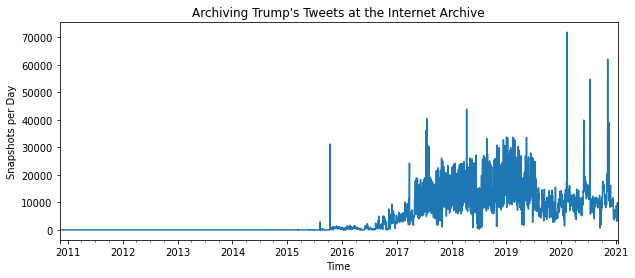

In [76]:
df.plot(
    kind='line',
    title="Archiving Trump's Tweets at the Internet Archive",
    figsize=(10, 4),
    legend=False,
    xlabel='Time',
    ylabel='Snapshots per Day'
)

Kinda noisy. Maybe it will look better as tweets-per-week?

<AxesSubplot:title={'center':"Archiving Trump's Tweets at the Internet Archive"}, xlabel='Time', ylabel='Snapshots per Week'>

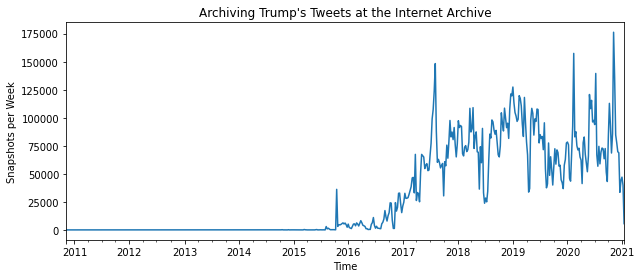

In [78]:
df = df.resample('W').sum().rename_axis('time')
df.plot(
    kind='line',
    title="Archiving Trump's Tweets at the Internet Archive",
    figsize=(10, 4),
    legend=False,
    xlabel='Time',
    ylabel='Snapshots per Week'
)

## Trump Archive URLs

To help media organizations update their links to point at snapshots at the Internet Archive I thought it could be useful to create a CSV dataset of the tweet ids and links. It's important to limit to known good tweets (within a particular range) and ones that returned a 200 OK. The latest snapshot will provide a picture of what interaction with that tweet looked like when the tweets were removed.

The situation is a bit tricky because just because there is a 200 OK response for a tweet URL in the Internet Archive doesn't mean its a good one to link to. For example this one seems to be OK but doesn't render: because of playback issues.

https://web.archive.org/web/20201112035441/https://twitter.com/realdonaldtrump/status/1698308935?s=21

What we can do is create a little function to make sure that it renders:

In [62]:
import requests_html

http = requests_html.AsyncHTMLSession()

async def response_ok(url, tries=10):
    global http
    try:
        resp = await http.get(url)
        await resp.html.arender(timeout=60)
        match = resp.html.search("Something went wrong")
        if match:
            return False
        return True
    except Exception as e:
        if tries == 0:
            raise e
        else:
            http = requests_html.AsyncHTMLSession()
            return await response_ok(url, tries - 1)

In [63]:
await response_ok('https://web.archive.org/web/20201112035441/https://twitter.com/realdonaldtrump/status/1698308935?s=21')

False

In [64]:
await response_ok('https://web.archive.org/web/20201106114341/https://twitter.com/realDonaldTrump/status/1776419923')

True

In [ ]:
sql = \
    """
    SELECT DISTINCT(CAST(tweet_id AS NUMERIC)) AS tweet_num
    FROM tweets
    WHERE tweet_num > 1698308934
      AND tweet_num < 1351984482019115009
    ORDER BY tweet_num ASC
    """

out = csv.writer(open('data/trump-tweet-archive.csv', 'w'))
out.writerow(['tweet_url', 'archive_url'])

count = 0
for row in db.execute(sql):
    tweet_id = row[0]
    sql = \
        """
        SELECT url, STRFTIME('%Y%m%d%H%M%S', timestamp)
        FROM tweets
        WHERE tweet_id = ?
        AND status_code = 200
        ORDER BY timestamp DESC
        """
    for [url, timestamp] in db.execute(sql, [tweet_id]):
        archive_url = 'https://web.archive.org/web/{}/{}'.format(timestamp, url)
        print('checking {}'.format(archive_url))
        if await response_ok(archive_url):
            tweet_url = 'https://twitter.com/realDonaldTrump/status/{}'.format(tweet_id)
            print('ok {} {}'.format(tweet_url, archive_url))
            out.writerow([tweet_url, archive_url])
            break

checking https://web.archive.org/web/20201112035441/https://twitter.com/realdonaldtrump/status/1698308935?s=21
checking https://web.archive.org/web/20201112032934/https://twitter.com/realdonaldtrump/status/1698308935
checking https://web.archive.org/web/20201112032721/https://twitter.com/realdonaldtrump/status/1698308935?lang=en
checking https://web.archive.org/web/20201108093337/https://twitter.com/realDonaldTrump/status/1698308935?ref_src=twsrc%5Etfw
checking https://web.archive.org/web/20201106114341/https://twitter.com/realDonaldTrump/status/1698308935
ok https://twitter.com/realDonaldTrump/status/1698308935 https://web.archive.org/web/20201106114341/https://twitter.com/realDonaldTrump/status/1698308935
checking https://web.archive.org/web/20201106114342/https://twitter.com/realDonaldTrump/status/1701461182
ok https://twitter.com/realDonaldTrump/status/1701461182 https://web.archive.org/web/20201106114342/https://twitter.com/realDonaldTrump/status/1701461182
checking https://web.ar

checking https://web.archive.org/web/20201106114336/https://twitter.com/realDonaldTrump/status/2184650461
ok https://twitter.com/realDonaldTrump/status/2184650461 https://web.archive.org/web/20201106114336/https://twitter.com/realDonaldTrump/status/2184650461
checking https://web.archive.org/web/20201106114336/https://twitter.com/realDonaldTrump/status/2222067805


RuntimeError: This event loop is already running

[E:pyppeteer.connection] connection unexpectedly closed
Task exception was never retrieved
future: <Task finished name='Task-62442' coro=<Connection._async_send() done, defined at /home/ed/.local/share/virtualenvs/notebooks-7Xlq9Gbm/lib/python3.8/site-packages/pyppeteer/connection.py:69> exception=InvalidStateError('invalid state')>
Traceback (most recent call last):
  File "/home/ed/.local/share/virtualenvs/notebooks-7Xlq9Gbm/lib/python3.8/site-packages/websockets/protocol.py", line 827, in transfer_data
    message = await self.read_message()
  File "/home/ed/.local/share/virtualenvs/notebooks-7Xlq9Gbm/lib/python3.8/site-packages/websockets/protocol.py", line 895, in read_message
    frame = await self.read_data_frame(max_size=self.max_size)
  File "/home/ed/.local/share/virtualenvs/notebooks-7Xlq9Gbm/lib/python3.8/site-packages/websockets/protocol.py", line 971, in read_data_frame
    frame = await self.read_frame(max_size)
  File "/home/ed/.local/share/virtualenvs/notebooks-7Xlq9Gb

## Top 10

What were the top 10 most archived tweets?

In [7]:
import sqlite3
import pandas
db = sqlite3.connect('data/trump-tweets.sqlite3')
df = pandas.read_csv('data/trump-archive.csv')

In [25]:
def get_text(tweet_id):
    v = df[df['id'] == tweet_id].text.values
    if len(v) != 0:
        return v[0]
    else:
        return "???"

get_text(1698308935)

'Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!'

In [28]:
sql = '''
    SELECT tweet_id, 
      COUNT(*) AS total
    FROM tweets
    GROUP BY tweet_id
    ORDER By total DESC
    LIMIT 10
    '''

for [tweet_id, total] in db.execute(sql):
    print('* [{}]({}) {}'.format(
        get_text(int(tweet_id)),
        'https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/{}'.format(tweet_id),
        total
    ))

* [Thank you Alabama! #Trump2016#SuperTuesday](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/704834185471598592) 65489
* [MAKE AMERICA GREAT AGAIN!](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/704756216157839360) 65360
* [Thank you Georgia!#SuperTuesday #Trump2016](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/704818842153971712) 65358
* [Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/796315640307060738) 55426
* [Watching the returns at 9:45pm. #ElectionNight #MAGA🇺🇸 https://t.co/HfuJeRZbod](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/796182637622816768) 54889
* [#ElectionDay https://t.co/MXrAxYnTjY https://t.co/FZhOncih21](https://web.archive.org/web/*/https://twitter.com/realDonaldTrump/status/796055597594578